In [1]:
import numpy as np
from scipy import interpolate
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
#Define the characteristic equation of the Heston Model
def heston_characteristic_function(u, params):
    iu = 1j * u
    
    kappa, theta, sigma, rho, v0, t, S0, r, q  = params['kappa'], params['theta'], params['sigma'], params['rho'], params['v0'], params['t'], params['S0'], params['r'], params['q']
    
    lambda_ = np.sqrt(sigma**2 * (u**2 + iu) + (kappa - iu * rho * sigma)**2)
    
    omega_numerator =  np.exp(iu * np.log(S0) + iu * (r - q) * t + kappa * theta * t * (kappa - iu * rho * sigma) / sigma**2)
    
    omega_denominator  = (np.cosh(lambda_ * t * 0.5) + (kappa - iu * rho * sigma) / lambda_ * np.sinh(lambda_ * t * 0.5))**(2 * kappa * theta * sigma**(-2))
    
    omega_u = omega_numerator/omega_denominator
    
    coth_lambda_t = 1/np.tanh(0.5 * lambda_ * t)  
    
    phi = omega_u * np.exp(-((u**2 + iu) * v0)/(lambda_ * coth_lambda_t + (kappa - iu * rho * sigma)))
    
    return phi


In [3]:
#Calculate the European Call Option Price of the Heston Model using FFT
def calc_fft_heston_call_prices(alpha, params, N, delta_v, K = None):
    #delta is the indicator function
    kappa, theta, sigma, rho, v0, t, S0, r, q  = params['kappa'], params['theta'], params['sigma'], params['rho'], params['v0'], params['t'], params['S0'], params['r'], params['q']
    
    begin = time.time()
    
    delta = np.zeros(N)
    delta[0] = 1 
    delta_k = (2*np.pi)/(N*delta_v)
    
    if K == None:
        #middle strike is at the money
        beta = np.log(S0) - delta_k*N*0.5 
        
    else:
        #middle strike is K
        beta = np.log(K) - delta_k*N*0.5
        
    k_list = np.array([(beta +(i-1)*delta_k) for i in range(1,N+1) ])
    v_list = np.arange(N) * delta_v
    
    #building fft input vector
    x_numerator = np.array( [((2-delta[i])*delta_v)*np.exp(-r*t)  for i in range(N)] )
    x_denominator = np.array( [2 * (alpha + 1j*i) * (alpha + 1j*i + 1) for i in v_list] )
    x_exp = np.array( [np.exp(-1j*(beta)*i) for i in v_list] )
    
    x_list = (x_numerator/x_denominator)*x_exp* np.array([heston_characteristic_function(i - 1j*(alpha+1),params) for i in v_list])
    
    #fft output
    y_list = np.fft.fft(x_list)
    #recovering prices
    prices = np.array( [(1/np.pi) * np.exp(-alpha*(beta +(i-1)*delta_k)) * np.real(y_list[i-1]) for i in range(1,N+1)] )
    
    end = time.time()
    deltatime = end - begin
    return prices, np.exp(k_list), deltatime


In [4]:
# Calculate option pricing integral using trapezoidal rule
def calc_option_price_via_quadrature(params, alpha, B, N, k):
    begin = time.time()
    dv = B / N  # Interval between nodes
    vj = np.arange(1, N+1) * dv  # Node positions
    j = complex(0, 1)
    
    # Calculate integral
    sum_val = 0.5 * (np.exp(-j * vj[0] * k) * heston_characteristic_function(vj[0] - (alpha + 1) * j, params) / (alpha + j * vj[0]) / (alpha + j * vj[0] + 1)).real
    for i in range(1, N):
        sum_val += (np.exp(-j * vj[i] * k) * heston_characteristic_function(vj[i] - (alpha + 1) * j, params) / (alpha + j * vj[i]) / (alpha + j * vj[i] + 1)).real
    sum_val += 0.5 * (np.exp(-j * vj[-1] * k) * heston_characteristic_function(vj[-1] - (alpha + 1) * j, params) / (alpha + j * vj[-1]) / (alpha + j * vj[-1] + 1)).real
    
    price = np.exp(-alpha * k) / np.pi * sum_val * dv

    end = time.time()
    deltatime = end - begin
    
    return np.exp(-params['r'] * params['t']) * price, deltatime


# (a) 

In [5]:
# Heston model parameters
params = {
    'S0': 250,  # Initial stock price
    'K': 250,  # Strike price
    't': 0.5,  # Time to maturity
    'r': 0.02,  # Risk-free rate
    'q': 0,  # Dividend yield
    'sigma': 0.2,  # Volatility of variance
    'v0': 0.08,  # Initial variance
    'kappa': 0.7,  # Rate of mean reversion
    'rho': -0.4,  # Correlation between asset and variance
    'theta': 0.1,  # Long-term variance
}

#### (i)

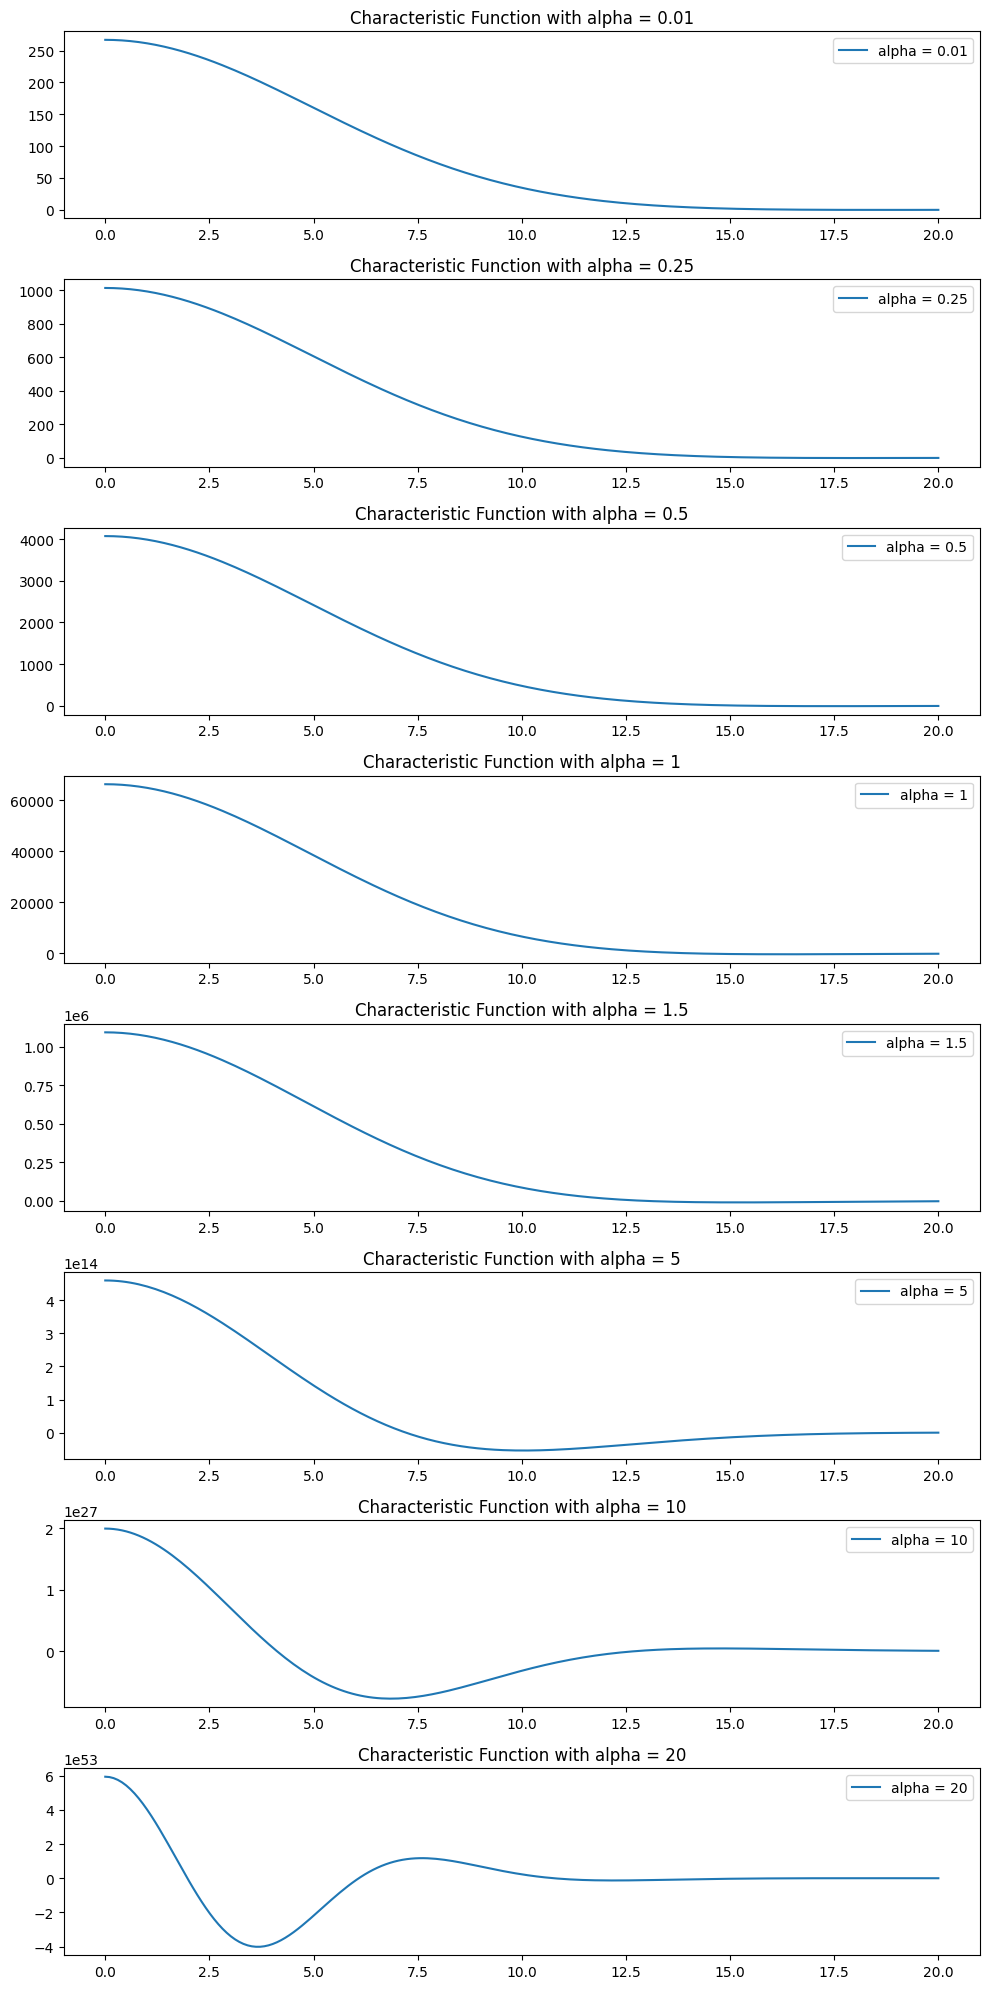

In [6]:
# Range of alpha values to explore
alpha_values = [0.01, 0.25, 0.5, 1, 1.5, 5, 10, 20]
v_values = np.linspace(0, 20, 200)

# Plot setup
fig, axes = plt.subplots(len(alpha_values), 1, figsize=(10, 20))

# Calculate and plot the function for each alpha
for i, alpha in enumerate(alpha_values):
    # Apply damping factor e^(-i*v*k) to the characteristic function
    characteristic = np.array([heston_characteristic_function(v - (alpha + 1)*1j, params) for v in v_values])
    damping_factor = np.exp(-1j * v_values * np.log(params['K']))
    function_values = np.real(damping_factor * characteristic)
    
    # Plotting
    ax = axes[i]
    ax.plot(v_values, function_values, label=f'alpha = {alpha}')
    ax.set_title(f'Characteristic Function with alpha = {alpha}')
    ax.legend()
    
plt.tight_layout()
plt.show()


The stability of the option pricing using FFT techniques with the Heston Model can be assessed by observing the behavior of the characteristic function across different values of the damping factor, α.

The stability of the price can be associated with how "smooth" and less oscillatory the characteristic function is.  Large oscillations or very steep changes would suggest instability in the pricing as α changes.  The more stable α values will show a characteristic function that changes gradually and without large oscillations.

From the graphs, We observed that:

Lower values of α (like 0.01, 0.25) show a smooth and gradually descending characteristic function, which suggests stability in these ranges.
As α increases, the characteristic function starts to increase in magnitude drastically (as seen in α = 1.5, 5), which might indicate instability or a less reliable price.
Very high values of α (like 20) show extreme behavior with large oscillations, which would be considered unstable and hence unsuitable for pricing.


Based on the image and the general rule for determining alpha (which is generally considered to be around 1), **we will select an alpha of 1.5** to price the European Call Option

The following code calculates the price of a European call option using the Quadrature method and the Fast Fourier Transform (FFT) method, respectively.

In [7]:
# Calculate option price
alpha = 1.5  # Damping factor
B = 100  # Upper bound of integration
N = 100000  # Number of nodes
k = np.log(params['K'])  # Log of strike price

option_price, computation_time  = calc_option_price_via_quadrature(params, alpha, B, N, k)
print("Quadrature method")
print(f"European Call Option Price: {option_price}")
print(f"Computation time: {computation_time} seconds")

# FFT parameters
alpha = 1.5      # Damping factor
N = 2**10        # Number of FFT points
delta_v = 0.25   # Step size in the frequency domain
K = 250          # Strike price, using the same value as S0 for this example

# Calculate option price
prices, strikes, computation_time = calc_fft_heston_call_prices(alpha, params, N, delta_v, K)

# Select a specific price to display, for example, the middle price
mid_index = len(prices) // 2
print("Fast Fourier Transform (FFT) method")
print(f"The option price at selected strike ({strikes[mid_index]}) is: {prices[mid_index]}")
print(f"Computation time: {computation_time} seconds")


Quadrature method
European Call Option Price: 21.245653604647057
Computation time: 0.6567461490631104 seconds
Fast Fourier Transform (FFT) method
The option price at selected strike (249.9999999999999) is: 21.268867212072852
Computation time: 0.010391712188720703 seconds


Comparing the Numerical Integration Method and Fast Fourier Transform (FFT) Method, it is found that the computed European Call Option Prices are basically the same, but the computation speed of the Fast Fourier Transform (FFT) Method is significantly faster.

#### (ii)

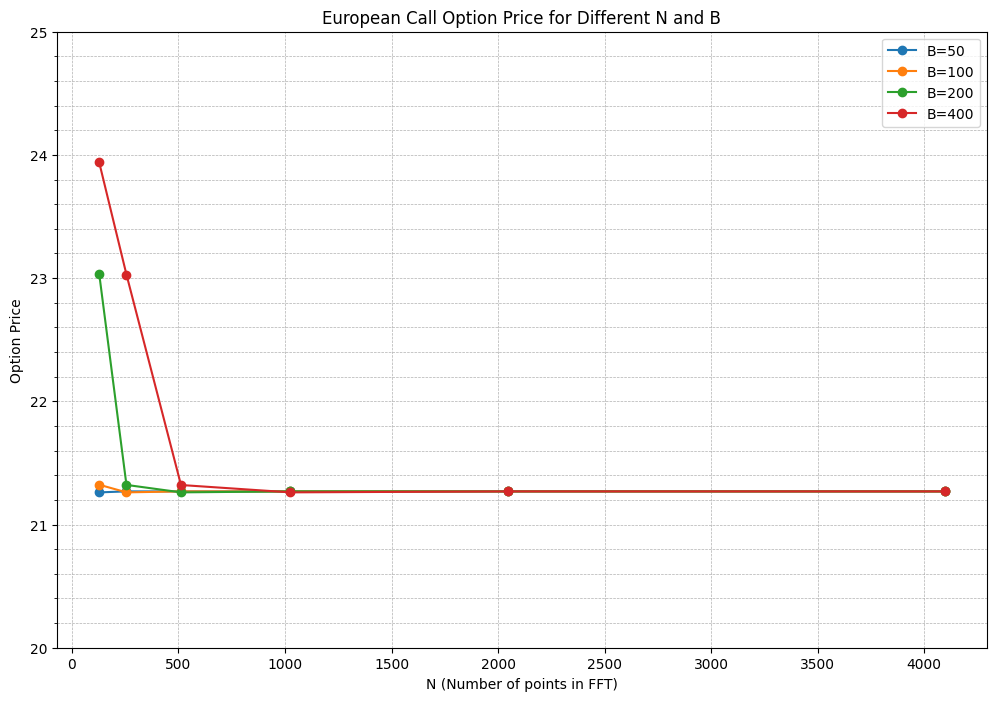

In [8]:
alpha_chosen = 1.5

# Define a range of N and B to test
N_values = [2**n for n in range(7, 13)]  # N as powers of 2 for FFT
B_values = [50, 100, 200, 400]  # Range of integration

# Calculate option prices for different N and B combinations
results_with_different_N = {B: [] for B in B_values}

# Set up the plot
plt.figure(figsize=(12, 8))

# Loop over each B value
for B in B_values:
    # Loop over each N value
    for N in N_values:
        # Assuming calc_fft_heston_call_prices is defined correctly and returns the prices and strike list
        prices, strikes, computation_time = calc_fft_heston_call_prices(alpha_chosen, params, N, 2 * np.pi / B, params['K'])
        
        # Find the price closest to strike price K
        strike_index = np.argmin(np.abs(strikes - params['K']))
        price_at_K = prices[strike_index]
        
        results_with_different_N[B].append(price_at_K)
    
    # Plot the option prices for different N for the current B value
    plt.plot(N_values, results_with_different_N[B], marker='o', linestyle='-', label=f'B={B}')

# Adjust y-axis to show the range 20-25 with all integer ticks
plt.ylim(20, 25)
plt.yticks(np.arange(20, 26, 1))

# Adding major and minor tick locator
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))  # Major ticks at every integer
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.2))  # Minor ticks at every 0.2

# Set grid to appear behind the plot elements
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
plt.gca().set_axisbelow(True)

# Finalize the plot
plt.title('European Call Option Price for Different N and B')
plt.xlabel('N (Number of points in FFT)')
plt.ylabel('Option Price')
plt.legend()
plt.show()


From the graph, We can see that: 
- As N increases, the option price seems to converge towards a certain value for each B.
- Beyond a certain N, increasing N further does not change the price significantly, suggesting that there is a point of diminishing returns where increasing N no longer contributes to a more accurate price and only adds to the computational cost.

From the observation we know that:
- beyond N=1024, the price does not change significantly.
- Choose a B that allows for this price stability at the lower N values. In the graph, B=50 and B=100 both seem to provide stable prices with N as low as 1024.

Therefore, we believe that using B=100 with N=1024 could be the most efficient parameterization.

#### (iii)

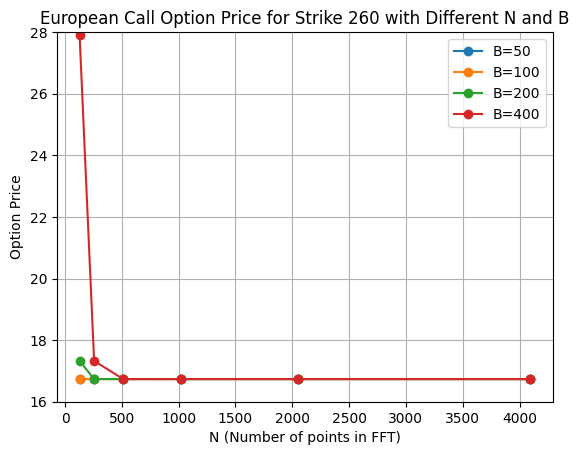

In [9]:
strike_price = 260  # New strike price

# Recalculate prices for the new strike price
results_for_strike_260 = {B: [] for B in B_values}
strike_prices_for_B = {B: [] for B in B_values}

for B in B_values:
    delta_k = (2 * np.pi) / B
    for N in N_values:
        delta_v = B / N
        prices, strikes, _ = calc_fft_heston_call_prices(alpha_chosen, params, N, delta_v, strike_price)
        
        # Find the price at the new strike price
        strike_index = np.argmin(np.abs(strikes - strike_price))
        price_at_new_strike = prices[strike_index]
        
        results_for_strike_260[B].append(price_at_new_strike)
        strike_prices_for_B[B].append(strikes[strike_index])

# Now, compare the results for each B and N
for B in B_values:
    plt.plot(N_values, results_for_strike_260[B], marker='o', linestyle='-', label=f'B={B}')

plt.title(f'European Call Option Price for Strike {strike_price} with Different N and B')
plt.xlabel('N (Number of points in FFT)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)

# Set the y-axis to display the 15-28 range
plt.ylim(16, 28)

plt.show()


The European Call Option Price changed as the strike_price varied, but the trend of changes following different values of N and B remained the same. Based on the price changes under different combinations of N and B, we can still select B=100 with N=1024 as the optimal parameterization.

# (b) 

In [10]:
from scipy.optimize import brentq
from scipy.stats import norm

# Update Heston model parameters
params = {
    'S0': 150,  # Initial stock price updated
    'K': 150,  # This will be updated in the loop
    't': 0.25,  # Time to maturity (3 months = 0.25 years)
    'r': 0.025,  # Risk-free rate updated to 2.5%
    'q': 0,  # Dividend yield
    'sigma': 0.4,  # Volatility of variance updated
    'v0': 0.09,  # Initial variance updated
    'kappa': 0.5,  # Rate of mean reversion updated
    'rho': 0.25,  # Correlation between asset and variance updated
    'theta': 0.12,  # Long-term variance updated
}

In [11]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(Heston_price, S, K, T, r):
    def difference(sigma): 
        return Heston_price - black_scholes_call(S, K, T, r, sigma)
    try:
        return brentq(difference, 1e-5, 2, maxiter=100)  # Extended upper bound for sigma
    except ValueError:
        return np.nan  # Return NaN if a solution cannot be found


#### (i)

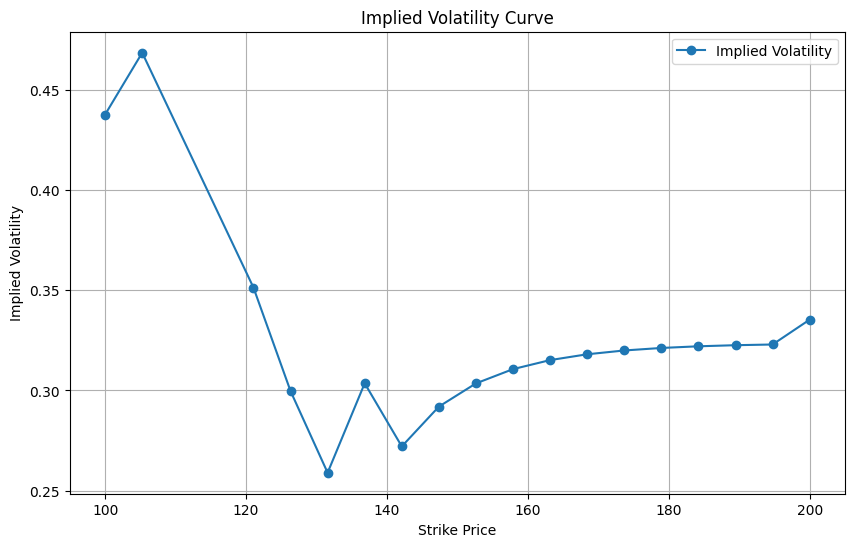

In [12]:
strikes = np.linspace(100, 200, 20)
ivs = []
strike_prices = []

alpha = 1.5  # Dampening factor
N = 2**10  # Number of points in FFT
B = 400
delta_v = B / N

# Ensure the calc_fft_heston_call_prices function is defined and available here
for K in strikes:
    params['K'] = K  # Update strike price
    # Assuming calc_fft_heston_call_prices returns the price for a specific K directly
    prices, ks, _ = calc_fft_heston_call_prices(alpha, params, N, delta_v)
    idx = np.argmin(np.abs(ks - K))  # Find the index of the strike closest to the current K
    Heston_price = prices[idx]
    iv = implied_volatility(Heston_price, params['S0'], K, params['t'], params['r'])
    if not np.isnan(iv):  # Only add valid implied volatilities
        ivs.append(iv)
        strike_prices.append(K)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, ivs, marker='o', label='Implied Volatility')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Curve')
plt.grid(True)
plt.legend()
plt.show()

#### (ii)

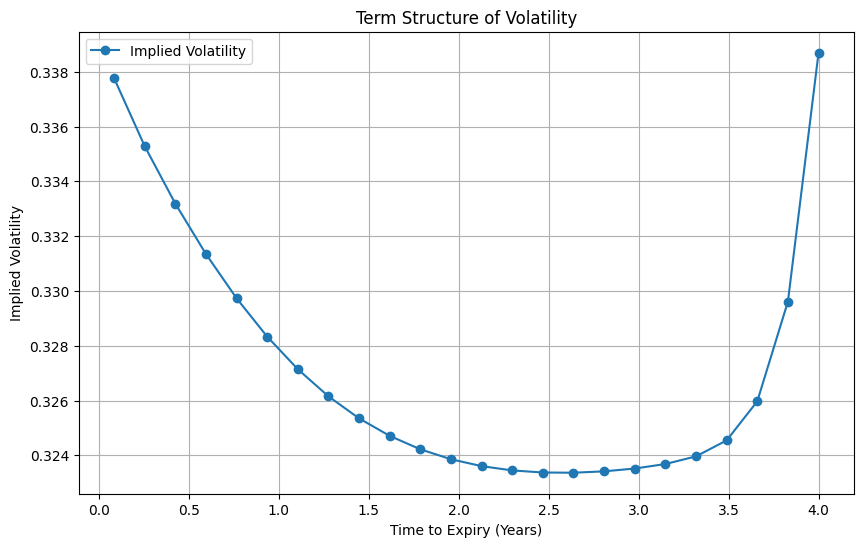

In [13]:
# Range of expiries in years
expiries = np.linspace(1/12, 4, 24)

# FFT setup
alpha = 1.5  # Dampening factor
N = 2**10  # Number of points in FFT
B = 400
delta_v = B / N

# Initialize lists for implied volatilities and expiries
ivs = []
valid_expiries = []

for t in expiries:
    params['t'] = t  # Update time to maturity
    prices, ks, _ = calc_fft_heston_call_prices(alpha, params, N, delta_v)
    K_index = np.argmin(np.abs(ks - params['K']))  # Find the index of the strike closest to the desired K
    Heston_price = prices[K_index]
    iv = implied_volatility(Heston_price, params['S0'], params['K'], t, params['r'])
    if not np.isnan(iv):  # Only add valid implied volatilities
        ivs.append(iv)
        valid_expiries.append(t)

# Plotting the term structure of volatility
plt.figure(figsize=(10, 6))
plt.plot(valid_expiries, ivs, marker='o', label='Implied Volatility')
plt.xlabel('Time to Expiry (Years)')
plt.ylabel('Implied Volatility')
plt.title('Term Structure of Volatility')
plt.grid(True)
plt.legend()
plt.show()

#### (iii)

In [16]:
# Define a function that calculates the Heston model call prices for a range of K and T
def heston_call_price(alpha, params, N, delta_v, K, T):
    params['t'] = T
    prices, strike_list, _ = calc_fft_heston_call_prices(alpha, params, N, delta_v, K)
    # Find the price closest to strike price K
    strike_index = np.argmin(np.abs(strike_list - K))
    return prices[strike_index]

/var/folders/j9/ryqgqp6n03schy65y0b0g4sm0000gn/T/ipykernel_34836/1736055751.py:53: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


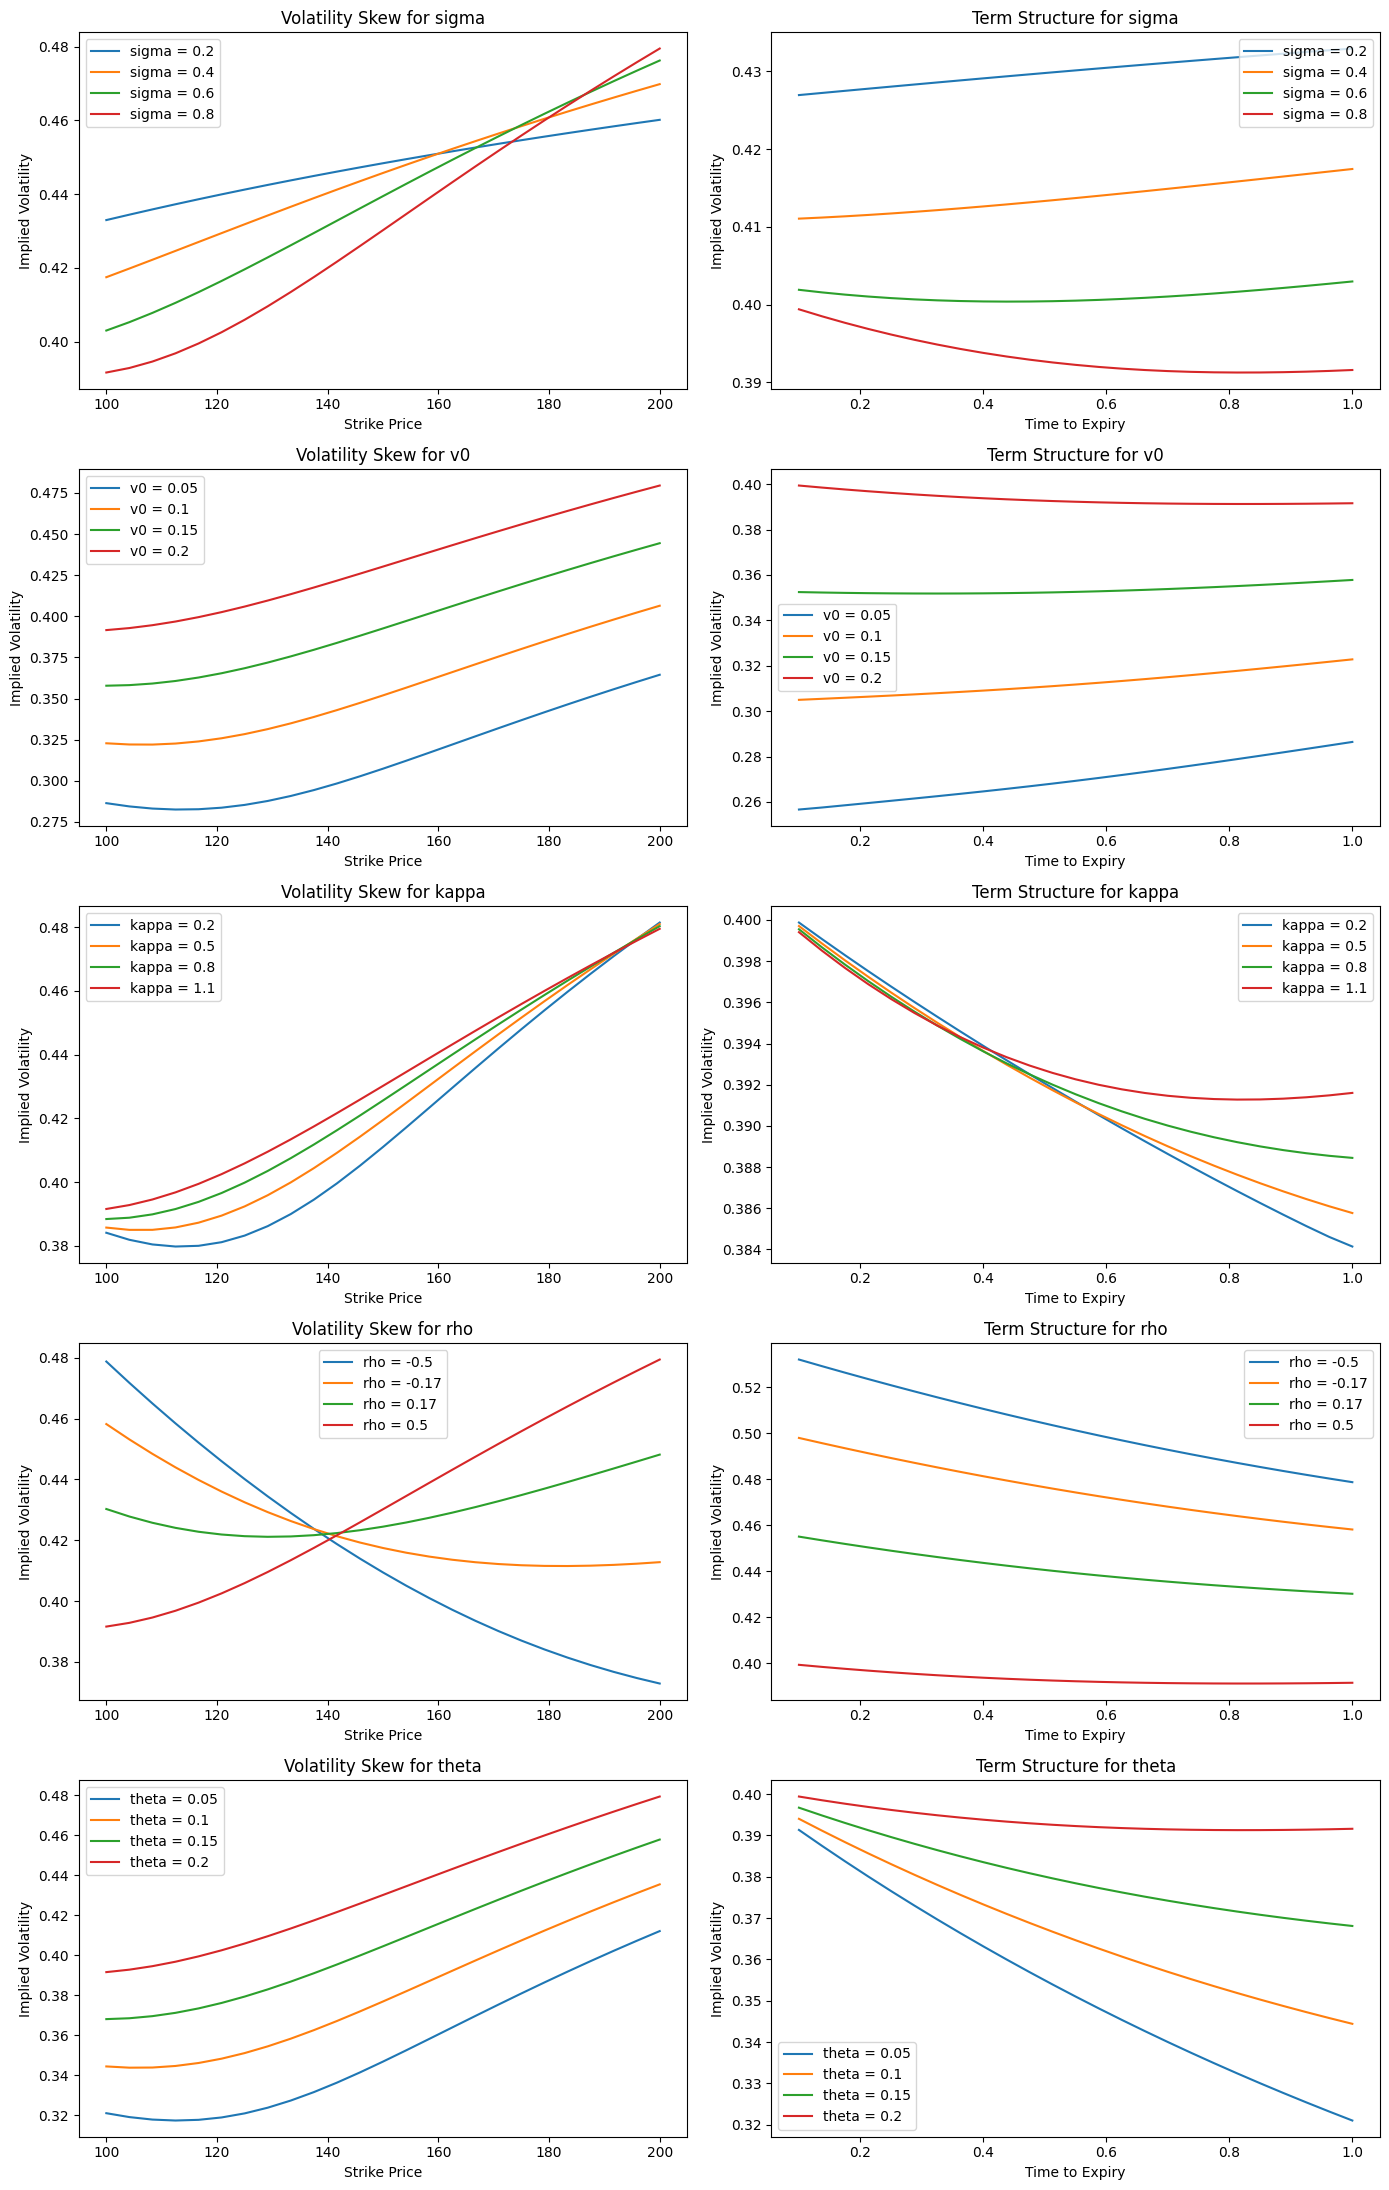

In [20]:
# Define the parameters for plotting
strike_prices = np.linspace(100, 200, 25)  # Range of strike prices
times_to_expiry = np.linspace(0.1, 1, 25)  # Range of times to expiry
alpha = 1.5  # Chosen alpha for the FFT calculation
N = 2**10  # Number of points in FFT
B = 400
delta_v = B / N

# Define the range of parameter values to plot
parameter_ranges = {
    'sigma': [round(x, 2) for x in np.linspace(0.2, 0.8, 4)],
    'v0': [round(x, 2) for x in np.linspace(0.05, 0.2, 4)],
    'kappa': [round(x, 2) for x in np.linspace(0.2, 1.1, 4)],
    'rho': [round(x, 2) for x in np.linspace(-0.5, 0.5, 4)],
    'theta': [round(x, 2) for x in np.linspace(0.05, 0.2, 4)],
}

# Set up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 22))
fig.tight_layout(pad=6.0)

# Loop over each parameter and plot the skew and term structure
for idx, (param, values) in enumerate(parameter_ranges.items()):
    for value in values:
        params[param] = value
        iv_skew = []
        iv_term_structure = []

        # Calculate implied volatilities across strike prices and expiries
        for K in strike_prices:
            Heston_price = heston_call_price(alpha, params, N, delta_v, K, params['t'])
            iv_skew.append(implied_volatility(Heston_price, params['S0'], K, params['t'], params['r']))
        
        for T in times_to_expiry:
            Heston_price = heston_call_price(alpha, params, N, delta_v, params['K'], T)
            iv_term_structure.append(implied_volatility(Heston_price, params['S0'], params['K'], T, params['r']))
        
        # Plot skew
        axes[idx, 0].plot(strike_prices, iv_skew, label=f'{param} = {value}')
        axes[idx, 0].set_xlabel('Strike Price')
        axes[idx, 0].set_ylabel('Implied Volatility')
        axes[idx, 0].set_title(f'Volatility Skew for {param}')
        axes[idx, 0].legend()

        # Plot term structure
        axes[idx, 1].plot(times_to_expiry, iv_term_structure, label=f'{param} = {value}')
        axes[idx, 1].set_xlabel('Time to Expiry')
        axes[idx, 1].set_ylabel('Implied Volatility')
        axes[idx, 1].set_title(f'Term Structure for {param}')
        axes[idx, 1].legend()

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plots
plt.show()


##### Volatility of Variance (σ):

Volatility Skew: Higher σ values lead to steeper volatility skews, indicating that the market is expecting more extreme outcomes (higher risk premium for out-of-the-money options).

Term Structure: As σ increases, the implied volatility generally decreases for all times to expiry, suggesting that the market expects lower volatility in the future when σ is higher.


##### Initial Variance (v0):

Volatility Skew: Higher initial variance levels increase the overall level of implied volatility and steepen the skew.

Term Structure: unlike σ, higher v0 values elevate the entire curve.


##### Rate of Mean Reversion (κ):

Volatility Skew: Different κ values result in different skew shapes, with higher κ values leading to a more pronounced skew, suggesting quicker reversion to the long-term variance will result in more pronounced differences in the implied volatility across strikes.

Term Structure: Higher κ values generally flatten the term structure, indicating a quicker reversion to long-term variance over time.


##### Correlation between Asset and Variance (ρ):

Volatility Skew: A positive rho will result in the strike price and implied volatility having a positive slope.

Term Structure: Larger ρ results in lower implied volatility over time.


##### Long-term Variance (θ):

Volatility Skew: Higher θ values lead to a higher level of implied volatility across all strikes.

Term Structure: Higher θ values tend to lift the entire term structure, however the implied volatility drops quicker with lower theta.